# Node Customization

@[Chaoming Wang](https://github.com/chaoming0625)

To implement a custom node in BrainPy, you will have to write a Python class that subclasses ``brainpy.nn.Node`` and implement several important methods. 

In [1]:
import brainpy as bp
import brainpy.math as bm

from brainpy.tools.checking import check_shape_consistency

bp.math.set_platform('cpu')

Before we start, you need to know the minimal knowledge about the ``brainpy.nn.Node``. Please see the tutorial of [Node Specification](../node_specification.ipynb). 

## Customizing a feedforward node

In general, the variable initialization and the logic computation of each node in ``brainpy.nn`` module are separated from each other. If not, applying JIT compilation to these nodes will be difficult. 

If your node only has feedforward connections, 

<center>
    <img src="../_static/feedforward_node.png" width="200 px" >
</center>

you need to implement two functions:

- ``init_ff()``: This function aims to initialize the feedforward connections and compute the output shape according to the given ``feedforward_shapes``. 
- ``forward()``: This function implement the main computation logic of the node. It may calculate the new state of the node. But most importantly, this function shoud return the output value for feedforward data flow. 

To show how this can be used, here is a node that multiplies its input by a matrix `W` (much like a typical fully connected layer in a neural network would). This matrix is a parameter of the layer. The shape of the matrix will be *(num_input, num_unit)*, where *num_input* is the number of input features and *num_unit* is the number of output features.

In [2]:
class DotNode(bp.nn.Node):
    def __init__(self, num_unit, W_initializer=bp.initialize.Normal(), **kwargs):
        super(DotNode, self).__init__(**kwargs)
        self.num_unit = num_unit
        self.W_initializer = W_initializer
    
    def init_ff(self):
        # This function should compute the output shape and  
        # the feedforward (FF) connections
        
        # 1. First, due to multiple FF shapes, we need to know 
        #    the total shape when all FF inputs are concatenated. 
        #    Function "check_shape_consistency()" may help you 
        #    solve this problem quickly.
        
        unique_size, free_sizes = check_shape_consistency(self.feedforward_shapes, -1, True)
        
        # 2. Initialize the weight W
        weight_shape = (sum(free_sizes), self.num_unit)
        self.W = bp.nn.parameter(self.W_initializer, weight_shape)
        #   If the user want to train this node, we need mark the 
        #   weight as a "brainpy.math.TrainVar"
        if self.trainable:
            self.W = bm.TrainVar(self.W)
        
        # 3. Set the output shape 
        self.set_output_shape(unique_size + (self.num_unit,))
        
    def forward(self, ff):
        # 1. First, we concatenate all FF inputs
        ff = bm.concatenate(ff, axis=-1)
        
        # 2. Then, we multiply the input with the weight
        return bm.dot(ff, self.W)

A few things are worth noting here: when overriding the constructor, we need to call the superclass constructor on the first line. This is important to ensure the node functions properly. Note that we pass ``**kwargs`` - although this is not strictly necessary, it enables some other cool features, such as making it possible to give the layer a name: 

In [3]:
DotNode(10, name='my_dot_node')

DotNode(name=my_dot_node, trainable=False, forwards=None, feedbacks=None, 
        output=None, support_feedback=False, data_pass_type=PASS_SEQUENCE)

Or, set this node trainable:

In [4]:
DotNode(10, trainable=True)

DotNode(name=DotNode0, trainable=True, forwards=None, feedbacks=None, 
        output=None, support_feedback=False, data_pass_type=PASS_SEQUENCE)

Once we create this ``DotNode``, we can connect multiple feedforward nodes to its instance. 

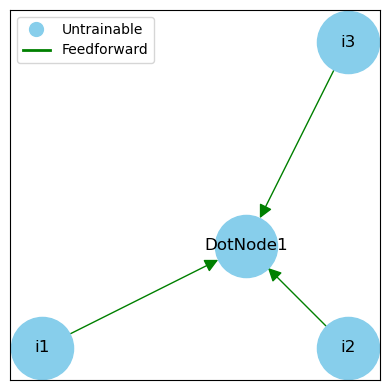

In [5]:
l = DotNode(10)
i1 = bp.nn.Input(1, name='i1')
i2 = bp.nn.Input(2, name='i2')
i3 = bp.nn.Input(3, name='i3')

net = {i1, i2, i3} >> l

net.plot_node_graph(fig_size=(4, 4), node_size=2000)

In [6]:
net.initialize(num_batch=1)

# given an input, let's compute its output
net({'i1': bm.ones((1, 1)), 
     'i2': bm.zeros((1, 2)), 
     'i3': bm.random.random((1, 3))})

JaxArray([[-0.41227022, -1.2145127 ,  1.2915486 , -1.7037894 ,
            0.47149402, -1.9161812 ,  1.3631151 , -0.4410456 ,
            1.9460022 ,  0.54992586]], dtype=float32)

## Customizing a recurrent node

If your node is a recurrent node, which means it has its own ``state`` and has a self-to-self connection weights, 

<center>
    <img src="../_static/recurrent_node.png" width="200 px" >
</center>

this time, you need to implement one more function:

- ``init_state(num_batch)``: This function aims to initialize the Node state which depends on the batch size. 

Furthermore, we recommend users' recurren node inherit from ``brainpy.nn.RecurrentNode``. Because this will instruct BrainPy to know it is a node has recurrent connections. 

Here, let's try to implement a Vanilla RNN model. 

In [7]:
class VRNN(bp.nn.RecurrentNode):
  def __init__(self, num_unit, 
               wi_initializer=bp.init.XavierNormal(),
               wr_initializer=bp.init.XavierNormal(), **kwargs):
    super(VRNN, self).__init__(**kwargs)
    
    self.num_unit = num_unit
    self.wi_initializer = wi_initializer
    self.wr_initializer = wr_initializer
    
  def init_ff(self):
    unique_size, free_sizes = check_shape_consistency(self.feedforward_shapes, -1, True)
    num_input = sum(free_sizes)
    self.wi = bp.nn.parameter(self.wi_initializer, (num_input, self.num_unit))
    self.wr = bp.nn.parameter(self.wr_initializer, (self.num_unit, self.num_unit))
    if self.trainable:
      self.wi = bm.TrainVar(self.wi)
      self.wr = bm.TrainVar(self.wr)
    
  def init_state(self, num_batch=1):
    state = bm.zeros((num_batch, self.num_unit))
    self.set_state(state)
  
  def forward(self, ff):
    ff = bm.concatenate(ff, axis=-1)
    state = ff @ self.wi + self.state @ self.wr
    self.state.value = state
    return state

## Customizing a node with feedbacks

Creating a layer receiving multiple feedback inputs is the same with the feedforward connections. 


<center>
    <img src="../_static/feedback_node.png" width="400 px" >
</center>

Users need to implement one more function, that is:

- ``init_fb()``: This function aims to initialize the feedback information, including the feedback connections, feedback weights, and others. 

For the above ``DotNode``, if try to support feedback connection, you can define the model like:

In [8]:
class FeedBackDotNode(bp.nn.Node):
  def __init__(self, num_unit, W_initializer=bp.initialize.Normal(), **kwargs):
    super(FeedBackDotNode, self).__init__(**kwargs)
    self.num_unit = num_unit
    self.W_initializer = W_initializer

  def init_ff(self):
    # 1. FF shapes
    unique_size, free_sizes = check_shape_consistency(self.feedforward_shapes, -1, True)
    # 2. Initialize the feedforward weight Wff
    weight_shape = (sum(free_sizes), self.num_unit)
    self.Wff = bp.nn.parameter(self.W_initializer, weight_shape)
    if self.trainable:
      self.Wff = bm.TrainVar(self.Wff)
    # 3. Set the output shape 
    self.set_output_shape(unique_size + (self.num_unit,))
  
  def init_fb(self):
    # 1. FB shapes
    unique_size, free_sizes = check_shape_consistency(self.feedback_shapes, -1, True)
    # 2. Initialize the feedback weight Wfb
    weight_shape = (sum(free_sizes), self.num_unit)
    self.Wfb = bp.nn.parameter(self.W_initializer, weight_shape)
    if self.trainable:
      self.Wfb = bm.TrainVar(self.Wfb)
    
  def forward(self, ff, fb=None):
    ff = bm.concatenate(ff, axis=-1)
    res = bm.dot(ff, self.Wff)
    if fb is None:
      fb = bm.concatenate(fb, axis=-1)
      res += bm.dot(fb, self.Wfb)
    return res

Note the difference between ``DotNode`` and ``FeedBackDotNode``. The ``forward()`` function of the latter has one argument ``fb=None``, which means if this node has feedback connections, it will pass all feedback inputs to ``fb`` argument. 

```{note}

Feedback connecting to a node which do not support feedbacks will raise an error.

```

In [9]:
try:
    DotNode(1) << bp.nn.Input(1)
except Exception as e:
    print(e.__class__)
    print(e)

<class 'ValueError'>
Establish a feedback connection to 
DotNode(name=DotNode2, trainable=False, forwards=None, feedbacks=None, 
        output=None, support_feedback=False, data_pass_type=PASS_SEQUENCE)
is not allowed. Because this node does not support feedback connections.


In [10]:
FeedBackDotNode(1) << bp.nn.Input(1)

Network(FeedBackDotNode0, Input1)

## Customizing a node with multiple behaviors

Some nodes can have multiple behaviors. For example, a node implementing *dropout* should be able to be switched on or off. During training, we want it to apply dropout noise to its input and scale up the remaining values, but during evaluation we don’t want it to do anything.

For this purpose, the ``forward()`` method takes optional keyword arguments (``kwargs``). When ``forward()`` is called to compute an expression for the output of a network, all specified keyword arguments are passed to the ``forward()`` methods of all layers in the network.

In [11]:
class Dropout(bp.nn.Node):
    def __init__(self, prob, seed=None, **kwargs):
        super(Dropout, self).__init__(**kwargs)
        self.prob = prob
        self.rng = bm.random.RandomState(seed=seed)

    def init_ff(self):
        assert len(self.feedback_shapes) == 1, 'Only support one feedforward input.'
        self.set_output_shape(self.feedforward_shapes[0])

    def forward(self, ff, **kwargs):
        assert len(ff) == 1, 'Only support one feedforward input.'
        if kwargs.get('train', True):
            keep_mask = self.rng.bernoulli(self.prob, ff[0].shape)
            return bm.where(keep_mask, ff[0] / self.prob, 0.)
        else:
            return ff[0]

``Dropout`` node only supports one feedforward input. Therefore we have some check at the beginning of ``init_ff()`` and  ``forward()`` functions. 